<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

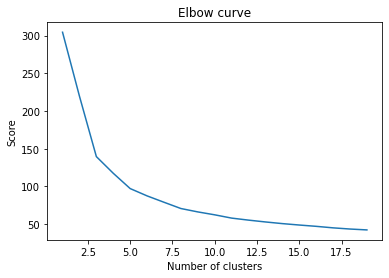

Complete >> Making elbow curve

There is No cluster in movie [Cockles and Muscles]
KMeans result: ['Nostalgia', 'Terminator 3: Rise of the Machines', 'Sleepless in Seattle', 'Young and Innocent', 'The Talented Mr. Ripley', 'Point Break', 'The 39 Steps', 'Once Were Warriors', 'The Hours', 'The Science of Sleep', 'Rain Man', 'The Million Dollar Hotel', 'Solaris', 'The Conversation', 'Sissi', 'Three Colors: Red', 'Monsoon Wedding', 'Titanic', 'A Nightmare on Elm Street', 'To Kill a Mockingbird', 'The Passion of Joan of Arc', 'Arlington Road', 'Reservoir Dogs'] 

apriori_kmeans_result: ['Nostalgia', 'Terminator 3: Rise of the Machines', 'Sleepless in Seattle', 'Young and Innocent', 'The Talented Mr. Ripley', 'Point Break', 'The 39 Steps', 'Once Were Warriors', 'The Hours', 'The Science of Sleep'] 

step  0  :   Rmse :  2.7768703107699793
step  5  :   Rmse :  0.9409013521501314
step  10  :   Rmse :  0.7758402128425621
step  15  :   Rmse :  0.651442002046812
step  20  :   Rmse :  0.546098845

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
import warnings

# Ignore warning messages for clean output
warnings.filterwarnings(action='ignore')




# Function : apriori_kmeans
def apriori_kmeans(user_input, movies_df_org, ratings_df_org):
    apriori_kmeans_result = []

    # Function : return [negative = 0, positive = 1]
    def apriori_encoding(r):
        if r <= 0:
            return 0
        elif r >= 1:
            return 1

    # Data preprocessing (drop)
    # Strange values
    movies_df_org.drop(movies_df_org.index[19730], inplace=True)
    movies_df_org.drop(movies_df_org.index[29502], inplace=True)
    movies_df_org.drop(movies_df_org.index[35585], inplace=True)

    # Remove the NaN title
    Nan_title = movies_df_org['title'].isna()
    movies_df = movies_df_org.loc[Nan_title == False]

    # Merge dataset with (movieId & id)
    movies_df = movies_df.astype({'id':'int64'})
    df = pd.merge(ratings_df_org, movies_df[['id','title','budget','popularity','revenue','runtime','vote_average','vote_count']], left_on='movieId', right_on='id')

    # Drop useless data
    df.drop(['timestamp', 'id'], axis=1, inplace=True)
    df.dropna(inplace=True)

    # Final check modified dataset
    print("================Cleaned Dataset====================")
    print(df.info(),'\n')

    # Results list
    apriori_result = []
    kmeans_result = []

    # Prepare Apriori
    df = df.drop_duplicates(['userId','title'])
    df_pivot = df.pivot(index='userId', columns='title', values='rating').fillna(0)
    df_pivot = df_pivot.astype('int64')
    df_pivot = df_pivot.applymap(apriori_encoding)

    # Apriori Algorithm (min_support=0.07, association_rules threshold=1)
    # Calculate support
    print("Start >> Making frequent_items...")
    frequent_items = apriori(df_pivot, min_support=0.07, use_colnames=True)
    print('frequent items:')
    print(frequent_items.head(10))
    print("Complete >> Making frequent_items\n")

    # Calculate confidence, lift using association rules
    print("Start >> Making association_rules...")
    association_indicator = association_rules(frequent_items, metric="lift")
    print('association indicator:')
    print(association_indicator.head(10))
    print("Complete >> Making association_rules\n")

    # Sort by order of lift
    print("Start >> Making lift dataset...")
    df_lift = association_indicator.sort_values(by=['lift'], ascending=False)
    print('df lift:')
    print(df_lift.head(10))
    print("Complete >> Making lift dataset\n")

    # Start recommendation
    for selected_movie in user_input:
        # The number of recommendations
        num = 0

        # Find lift > 1.2 movies
        df_selected = df_lift[df_lift['antecedents'].apply(lambda x: len(x) == 1 and next(iter(x)) == selected_movie)]
        df_selected = df_selected[df_selected['lift'] > 1.2]
        recommended_movies = df_selected['consequents'].values

        # Save results
        for movie in recommended_movies:
            for title in movie:
                # Avoiding duplication
                if title not in apriori_result and title not in user_input and num < 10:
                    apriori_result.append(title)
                    num += 1

    # Check Apriori result
    print('Apriori result:',apriori_result,"\n")

    # Prepare KMeans
    clusters = []

    # Get numeric type columns
    numeric_df = movies_df_org[['budget','popularity','revenue','runtime','vote_average','vote_count','title']]

    # Drop null values
    numeric_df.isnull().sum()
    numeric_df.dropna(inplace=True)

    # Cut off the movies' votes less than 25
    df_numeric = numeric_df[numeric_df['vote_count']>25]

    # Normalize data
    minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop('title', axis=1))
    df_numeric_scaled = pd.DataFrame(
        minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-1])

    # KMeans Algorithm
    # make elbow curve to determine value 'k'
    print("Start >> Making elbow curve...")
    num_cluster = range(1, 20)
    kmeans = [KMeans(n_clusters=i) for i in num_cluster]
    score = [kmeans[i].fit(df_numeric_scaled).inertia_ for i in range(len(kmeans))]

    # print elbow curve
    pl.plot(num_cluster, score)
    pl.xlabel("Number of clusters")
    pl.ylabel("Score")
    pl.title("Elbow curve")
    plt.show()
    print("Complete >> Making elbow curve\n")

    # Fit K-means clustering for k=5
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_numeric_scaled)

    # Write back labels to the original numeric data frame
    df_numeric['cluster'] = kmeans.labels_

    # Search all clusters in user selected movies
    for movie1 in user_input:
        try:
            cluster_candid = df_numeric.loc[df_numeric["title"] == movie1, 'cluster'].values[0]
            # print(cluster_candid)
            clusters.append(cluster_candid)
        except IndexError as e:
            msg = "There is No cluster in movie [" + movie1 + ']'
            print(msg)

    # Filtering movies that are not in clusters
    for movie2 in apriori_result:
        try:
            cluster_tmp = df_numeric.loc[df_numeric["title"] == movie2, 'cluster'].values[0]
            if cluster_tmp in clusters:
                kmeans_result.append(movie2)
        except IndexError as e:
            msg = "There is No cluster in movie [" + movie2 + ']'
            print(msg)

    print('KMeans result:',kmeans_result,'\n')

    # Select top 10
    apriori_kmeans_result = kmeans_result[:10]
    print('apriori_kmeans_result:',apriori_kmeans_result,'\n')

    # Return apriori_kmeans result
    return apriori_kmeans_result




# Function : content_based
def content_based(user_input, movies_df):
    content_based_result = []

    # Preprocessing
    # Select data to use
    movies_df = movies_df[['id', 'genres', 'vote_average', 'vote_count', 'popularity', 'title', 'overview']]

    # Handling of vote unfair issues
    # The more vote, the lower the vote average

    # reference : https://www.quora.com/How-does-IMDbs-rating-system-work
    # r : individual movie ratings
    # v : Number of times you voted for an individual movie
    # m : Minimum number of votes to be in the top 500
    # c : an average rating for an entire movie

    m = movies_df['vote_count'].quantile(0.9)
    movies_df = movies_df.loc[movies_df['vote_count'] >= m]
    C = movies_df['vote_average'].mean()

    def improved_rating(x, m=m, C=C):
        v = x['vote_count']
        R = x['vote_average']

        return (v / (v + m) * R) + (m / (m + v) * C)

    movies_df['score'] = movies_df.apply(improved_rating, axis=1)

    #  Don't need an id value, so remove it and  just pull out the name
    movies_df['genres'] = movies_df['genres'].apply(literal_eval)
    movies_df['genres'] = movies_df['genres'].apply(lambda x: [d['name'] for d in x]).apply(lambda x: " ".join(x))

    # TF-IDF vectorization
    TFIDF_vector = TfidfVectorizer()
    TFIDF_matrix = TFIDF_vector.fit_transform(movies_df['genres']).toarray()
    TFIDF_matrix_feature = TFIDF_vector.get_feature_names()

    TFIDF_matrix = pd.DataFrame(TFIDF_matrix, columns=TFIDF_matrix_feature, index=movies_df.title)

    # cosine_similarity
    cosine_sim = cosine_similarity(TFIDF_matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df.title, columns=movies_df.title)

    def movie_genre_recommendations(movie_title, matrix, items, k=10):
        recommend_idx = matrix.loc[:, movie_title].values.reshape(1, -1).argsort()[:, ::-1].flatten()[1:k + 1]
        recommend_title = items.iloc[recommend_idx, :].title.values
        recommend_genre = items.iloc[recommend_idx, :].genres.values

        target_title_list = np.full(len(range(k)), movie_title)
        target_genre_list = np.full(len(range(k)), items[items.title == movie_title].genres.values)
        d = {
            'target_title': target_title_list,
            'target_genre': target_genre_list,
            'recommend_title': recommend_title,
            'recommend_genre': recommend_genre
        }
        return pd.DataFrame(d)

    content_based_result = movie_genre_recommendations(user_input, cosine_sim_df, movies_df)

    return list(content_based_result['recommend_title'])




# Function : collaborate
def collaborate(user_input,movies_df,ratings_df):
    collaborate_result = []

    # Function : rmse
    def rmse(R, P, Q, values):
        # Generating the predictive R matrix as the dot product of the two decomposed matrices P and Q.T
        predict_matrix = np.dot(P, Q.T)
        
        # Calculate Rmse of R matrix and prediction matrix
        x_values = [Exist_val[0] for Exist_val in values]
        y_values = [Exist_val[1] for Exist_val in values]
        R_values = R[x_values, y_values]
        
        Result_matrix = predict_matrix[x_values, y_values]
        
        mse = mean_squared_error(R_values, Result_matrix)
        rmse = np.sqrt(mse)
        
        return rmse

    # Function : matrix factorization
    def matrix_factorization(R, K, step=150, Lambda = 0.01,learning_rate=0.01):
        
        user, item = R.shape
        # Size and create a matrix and fill it with random values
        np.random.seed(1)
        P = np.random.normal(scale=1./K, size=(user, K))
        Q = np.random.normal(scale=1./K, size=(item, K))
    
            
        # Stores non-zero values ​​of rows and columns
        Values = [ (i, j, R[i,j]) for i in range(user) for j in range(item) if R[i,j] > 0 ]
        
        # Optimizing P and Q matrices with stochastic gradient descent(SGD)
        for step in range(step):
            for i, j, r in Values:
                # Find the error value, which is the difference between the actual value and the predicted value
                eij = r - np.dot(P[i, :], Q[j, :].T)
                # Application of SGD update formula reflecting regularization
                P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - Lambda*P[i,:])
                Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - Lambda*Q[j,:])
            
            Rmse = rmse(R, P, Q, Values)
            if (step % 5) == 0 :
                print("step ",step," : ", " Rmse : ", Rmse)
                
        return P, Q

    # Function : recommend_movies
    def recommend_movies(svd_preds, user_id, movies, ratings, num=10):
        user_row_number = user_id - 1 
        
        # Sort the movie ratings for that user in descending order
        sort_pred = svd_preds.iloc[user_row_number].sort_values(ascending=False)
        
        # Extracting user-specific information from original rating data
        user_data = ratings[ratings.userId == user_id]

        # Merge User information and original movie data
        history = user_data.merge(movies, on = 'movieId').sort_values(['rating'], ascending=False)
    
        # Exclude user history from original movie data
        Recommendation = movies[~movies['movieId'].isin(history['movieId'])]
    
        # Merge the user's rating in the prediction matrix with data excluding history 
        Recommendation = Recommendation.merge( pd.DataFrame(sort_pred).reset_index(), on = 'movieId')
        Recommendation = Recommendation.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num, :]

        return Recommendation

    #Remove unnecessary columns
    movies_df = movies_df.drop(labels=[
        'adult',
        'belongs_to_collection',
        'budget',
        'homepage',
        'imdb_id',
        'original_language',
        'original_title',
        'overview',
        'poster_path',
        'popularity',
        'production_companies',
        'production_countries',
        'release_date',
        'spoken_languages',
        'status',
        'tagline',
        'video',
        'vote_average',
        'vote_count',
        'revenue',
        'runtime'], axis=1)
    movies_df.dropna(inplace=True)

    movies_df.rename(columns={'id':'movieId'},inplace=True)
    movies_df = movies_df.astype({'movieId':'int64'})

    #Movies that have not been rated are NaN values, so they are filled with 0.
    user_movie_ratings = ratings_df.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    ).fillna(0)

    # Optimal P, Q matrix
    P, Q = matrix_factorization(user_movie_ratings.values, K=50, step=150, learning_rate=0.01, Lambda = 0.01)

    # Create prediction matrix
    pred_matrix = np.dot(P, Q.T)

    # Convert to dataframe for movie recommendation based on that matrix
    svd_df = pd.DataFrame(pred_matrix, columns = user_movie_ratings.columns)

    # Prediction
    predictions = recommend_movies(svd_df, user_input, movies_df, ratings_df, 10)
    print("Recommendation result : \n",predictions)
    collaborate_result=list(predictions['title'])

    return collaborate_result




# Function : MainFunction - Whole Process
def MainFunction(apriori_KMeans_input, content_based_input, collaborate_input, movies_df, ratings_df):
    final_result = []
    # Calculate recommendations
    final_result.append('apriori_kmeans_result: '+ str(apriori_kmeans(apriori_KMeans_input,movies_df,ratings_df))+'\n')
    final_result.append('content_based_input: '+ str(content_based(content_based_input,movies_df))+'\n')
    final_result.append('collaborate_input: '+ str(collaborate(collaborate_input,movies_df,ratings_df)))

    # Print results
    print("================================================================")
    print('\n'.join(final_result))
    print("================================================================")




# Main =================================================
# Read datasets
movies_df_org = pd.read_csv('data/movies_metadata.csv')
ratings_df_org = pd.read_csv('data/ratings_small.csv')

# Data Exploration
print("=====================================================")
print(movies_df_org.info(),'\n')
print(ratings_df_org.info(),'\n')

# apriori_KMeans_input (5 movies)
input1 = ['Men in Black II','48 Hrs.','Contempt','The Dark','2001: A Space Odyssey']
# content_based_input (1 movie)
input2 = 'Men in Black II'
# collaborate_input (User ID)
input3 = 15

# Run!
MainFunction(
    apriori_KMeans_input=input1, 
    content_based_input=input2, 
    collaborate_input=input3, 
    movies_df=movies_df_org, 
    ratings_df=ratings_df_org
    )